In [53]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict

## Recall

In [54]:
# Functions for loading recall, precision, and gradnorm

def load_file(pth):
    with open(pth) as f:
        lines = f.readlines() 
    return lines 

def get_ordered_dict(k_lst, v_lst):
    return OrderedDict(sorted(zip(k_lst, v_lst), key=lambda x: x[0]))

def filter_df(df, pth):
    if "trec-covid" in pth:
        pth = "/gallery_louvre/dayoon.ko/research/sds/src/datasets/trec-covid/qrels/test.tsv"
        df_org = pd.read_csv(pth, sep="\t")
        ids = df_org[df_org["score"] == 2]["corpus-id"].tolist()
        print("Before:", len(df))
        df = df[df["corpus-id"].isin(ids)]
        print("After:", len(df))
    return df
    
def get_recalls_and_precisions(pth, selected_cids):
    df = pd.read_csv(pth)
    df = df.drop('Unnamed: 0', axis=1)
    df = df[df["corpus-id"].isin(selected_cids)]
    df.loc[df["precision"] < 0, "precision"] = 0
    #if "trec-covid" in pth:
    #    df = filter_df(df, pth)
    corpus_ids = df['corpus-id'].tolist()
    recalls = df['recall'].tolist()
    precisions = df['precision'].tolist()
    recall_dict = get_ordered_dict(corpus_ids, recalls)
    precision_dict = get_ordered_dict(corpus_ids, precisions)
    return recall_dict, precision_dict

def get_gradnorms(pth, gradnorm_func="mean"):
    lines = load_file(pth)
    gradnorms = []
    for l in lines:
        try: 
            l = l.replace('\'', '"')
            item = json.loads(l)
            gradnorms.append(float(item["grad_norm"]))
        except Exception as e:
            continue
    ids = []
    for l in lines:
        try:
            sid = l.index("doc_id: ") + len("doc_id: ") 
            ids.append(l[sid:].strip())
        except Exception as e:
            continue

    gradnorms_selected = []
    ids_selected = []
    func = lambda x: min(x) if gradnorm_func == "min" else sum(x) / len(x)
    for i in range(0, len(ids), 16):
        gradnorms_selected.append(func(gradnorms[i:i+n_aug]))
        ids_selected.append(ids[i])
    gradnorm_dict = get_ordered_dict(ids_selected, gradnorms_selected)
            
    return gradnorm_dict


In [55]:
model_name = ["bge-large-en-v1.5", "contriever", "gte-base", "multilingual-e5-large"][0]
dataset_name = ["nfcorpus", "trec-covid", "climate-fever"][2]
dropout=["", "-0.02", "-0.05"][1]
temp=[0.01, 0.05, 0.1][1]
root = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/"
recall_path = root + f"retrieval/results/{model_name}/{dataset_name}-n-query-mt-2.csv"
gradnorm_path = root + f"{model_name}/{dataset_name}-result{dropout}-temp-{temp}"
n_aug = 16
gradnorm_func = ("min", "mean")[1]

In [56]:
def get_result(
    model_name,
    dataset_name,
    dropout,
    temperature,
    root,
    n_aug,
    gradnorm_func,
    interval=5
):
    # Load results
    gradnorm_path = root + f"gradnorm/{model_name}/{dataset_name}-result{dropout}-temp-{temp}"
    gradnorm_dict = get_gradnorms(gradnorm_path)
    recall_path = root + f"retrieval/results/{model_name}/{dataset_name}-n-query-mt-2.csv"
    recall_dict, precision_dict = get_recalls_and_precisions(recall_path, gradnorm_dict.keys())
    gradnorm_dict = {i: gradnorm_dict[i] for i in recall_dict.keys()}
    
    def linear_regression(x_dict, y_dict):
        xs = [i[1] for i in x_dict.items()]
        ys = [i[1] for i in y_dict.items()]
        slope, y_intercept = np.polyfit(xs, ys, deg=1)
        print("Linear regression:", round(slope, 2), "* x", 
              "+" if y_intercept > 0 else "-", np.abs(y_intercept))

    def calculate_avg_for_each_interval(gradnorm_dict, metric_dict, interval):
        integrated_output = [[gradnorm_dict[i], metric_dict[i]] for i in metric_dict.keys()]
        integrated_output = sorted(integrated_output, key=lambda x: x[0], reverse=True)
        #if model_name == "gte-base" and dropout == "-0.02" and temperature == 0.05:
        #for i in integrated_output:
        #    print(i)
        latex = ""
        for r in range(interval):
            start_percentage = r / interval
            end_percentage = (r+1) / interval
            start = int(len(integrated_output) * start_percentage)
            end = int(len(integrated_output) * end_percentage)
            sub_output = integrated_output[start:end]
            scores = [i[1] for i in sub_output]
            mean = round(sum(scores) / len(scores), 3)
            print(f"Gradnorm Top {100-int(start_percentage * 100)} - {100-int(end_percentage * 100)} % :", mean)
            latex += f" {round(sum(scores) / len(scores) * 100, 1)} &"
        print(latex)
            
    print(f"\n=============={model_name} {dataset_name} {dropout} {temperature}=================\n")
    print("\nRecall\n")
    linear_regression(recall_dict, gradnorm_dict)
    calculate_avg_for_each_interval(gradnorm_dict, recall_dict, interval)
    print("\nPrecision\n")
    linear_regression(precision_dict, gradnorm_dict)
    calculate_avg_for_each_interval(gradnorm_dict, precision_dict, interval)
    
    

In [57]:
get_result(
    model_name="gte-base",
    dataset_name="trec-covid",
    dropout="-0.05",
    temperature=0.01,
    root=root,
    n_aug=n_aug,
    gradnorm_func=gradnorm_func
)


==============gte-base trec-covid -0.05 0.01=================


Recall

Linear regression: 1.19 * x + 15.171463018566863
Gradnorm Top 100 - 80 % : 0.108
Gradnorm Top 80 - 60 % : 0.11
Gradnorm Top 60 - 40 % : 0.096
Gradnorm Top 40 - 20 % : 0.094
Gradnorm Top 20 - 0 % : 0.09
 10.8 & 11.0 & 9.6 & 9.4 & 9.0 &

Precision

Linear regression: 0.28 * x + 15.211157109219986
Gradnorm Top 100 - 80 % : 0.282
Gradnorm Top 80 - 60 % : 0.31
Gradnorm Top 60 - 40 % : 0.269
Gradnorm Top 40 - 20 % : 0.293
Gradnorm Top 20 - 0 % : 0.261
 28.2 & 31.0 & 26.9 & 29.3 & 26.1 &


In [60]:
root = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/"
n_aug = 16
gradnorm_func = ("min", "mean")[1]

for dataset_name in ["climate-fever"]:
    for model_name in ["gte-base", "multilingual-e5-large"]:
         for dropout in ["-0.02", "-0.05"]: #, "-0.05"]:
            for temp in [0.01, 0.05, 0.1]:
                get_result(
                    model_name,
                    dataset_name,
                    dropout,
                    temp,
                    root,
                    n_aug,
                    gradnorm_func,
                    interval = 4
                )


==============gte-base climate-fever -0.02 0.01=================


Recall

Linear regression: 1.78 * x + 4.012536308562625
Gradnorm Top 100 - 75 % : 0.581
Gradnorm Top 75 - 50 % : 0.498
Gradnorm Top 50 - 25 % : 0.463
Gradnorm Top 25 - 0 % : 0.466
 58.1 & 49.8 & 46.3 & 46.6 &

Precision

Linear regression: 0.71 * x + 4.767765390262522
Gradnorm Top 100 - 75 % : 0.191
Gradnorm Top 75 - 50 % : 0.235
Gradnorm Top 50 - 25 % : 0.172
Gradnorm Top 25 - 0 % : 0.171
 19.1 & 23.5 & 17.2 & 17.1 &

==============gte-base climate-fever -0.02 0.05=================


Recall

Linear regression: -0.22 * x + 13.082496387151085
Gradnorm Top 100 - 75 % : 0.472
Gradnorm Top 75 - 50 % : 0.51
Gradnorm Top 50 - 25 % : 0.563
Gradnorm Top 25 - 0 % : 0.461
 47.2 & 51.0 & 56.3 & 46.1 &

Precision

Linear regression: 0.83 * x + 12.810744143318871
Gradnorm Top 100 - 75 % : 0.213
Gradnorm Top 75 - 50 % : 0.215
Gradnorm Top 50 - 25 % : 0.173
Gradnorm Top 25 - 0 % : 0.168
 21.3 & 21.5 & 17.3 & 16.8 &

==============gte

FileNotFoundError: [Errno 2] No such file or directory: '/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/gradnorm/multilingual-e5-large/climate-fever-result-0.02-temp-0.01'

### Bi-Partition the result

In [61]:
def get_result_with_partitioning(
    model_name,
    dataset_name,
    dropout,
    temperature,
    root,
    n_aug,
    gradnorm_func,
    baseline
):
    # Load results
    gradnorm_path = root + f"gradnorm/{model_name}/{dataset_name}-result{dropout}-temp-{temp}"
    gradnorm_dict = get_gradnorms(gradnorm_path)
    recall_path = root + f"retrieval/results/{model_name}/{dataset_name}-n-query-mt-2.csv"
    recall_dict, precision_dict = get_recalls_and_precisions(recall_path, gradnorm_dict.keys())

    def calculate_avg_for_each_interval(gradnorm_dict, metric_dict, baseline):
        integrated_output = [[gradnorm_dict[i], metric_dict[i]] for i in metric_dict.keys()]
        gradnorm_high = [metric_dict[i] for i in metric_dict.keys() if gradnorm_dict[i] >= baseline]
        gradnorm_low = [metric_dict[i] for i in metric_dict.keys() if gradnorm_dict[i] < baseline]
        mean_above = round(sum(gradnorm_high) / len(gradnorm_high), 3) if len(gradnorm_high) > 0 else 0
        mean_below = round(sum(gradnorm_low) / len(gradnorm_low), 3)
        print(f"Above (GN > {baseline} : {mean_above} ({len(gradnorm_high)})")
        print(f"Below (GN < {baseline} : {mean_below} ({len(gradnorm_low)})")

    print(f"\n=============={model_name} {dataset_name} {dropout} {temperature}=================\n")
    print("\nRecall\n")
    calculate_avg_for_each_interval(gradnorm_dict, recall_dict, baseline)
    print("\nPrecision\n")
    calculate_avg_for_each_interval(gradnorm_dict, precision_dict, baseline)
    
    

In [62]:
root = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/"
n_aug = 16
gradnorm_func = ("min", "mean")[1]

baselines = {"bge-large-en-v1.5": 18.02, 
            "contriever": 16.08,
            "gte-base": 16.57,
            "multilingual-e5-large": 24.53
           }
for model_name in ["bge-large-en-v1.5", "contriever", "gte-base", "multilingual-e5-large"]:
    for dataset_name in ["nfcorpus", "trec-covid"]:
         for dropout in ["", "-0.02", "-0.05"]:
            for temp in [0.01, 0.05, 0.1]:
                get_result_with_partitioning(
                    model_name,
                    dataset_name,
                    dropout,
                    temp,
                    root,
                    n_aug,
                    gradnorm_func,
                    baselines[model_name]
                )
# me5: 24.53
# contriever: 16.08
# bge-large: 18.02
# gte: 16.57
                
# bge - 53 (0.139 / 0.235) / contriever - 1266 (0.160 / 0.201) / gte - 37 (0.301 / 0.24) ... / me5 - 1006 (0.173 / 0.219)  


==============bge-large-en-v1.5 nfcorpus  0.01=================


Recall

Above (GN > 18.02 : 0.0 (3)
Below (GN < 18.02 : 0.219 (1430)

Precision

Above (GN > 18.02 : 0.0 (3)
Below (GN < 18.02 : 0.019 (1430)

==============bge-large-en-v1.5 nfcorpus  0.05=================


Recall

Above (GN > 18.02 : 0.166 (33)
Below (GN < 18.02 : 0.234 (1902)

Precision

Above (GN > 18.02 : 0.029 (33)
Below (GN < 18.02 : 0.018 (1902)

==============bge-large-en-v1.5 nfcorpus  0.1=================


Recall

Above (GN > 18.02 : 0 (0)
Below (GN < 18.02 : 0.233 (1935)

Precision

Above (GN > 18.02 : 0 (0)
Below (GN < 18.02 : 0.018 (1935)

==============bge-large-en-v1.5 nfcorpus -0.02 0.01=================


Recall

Above (GN > 18.02 : 0.0 (4)
Below (GN < 18.02 : 0.233 (1934)

Precision

Above (GN > 18.02 : 0.0 (4)
Below (GN < 18.02 : 0.018 (1934)

==============bge-large-en-v1.5 nfcorpus -0.02 0.05=================


Recall

Above (GN > 18.02 : 0.139 (53)
Below (GN < 18.02 : 0.235 (1885)

Precision

Ab

### Visualize plots

In [65]:
def get_result_dataset_model(
    model_name,
    dataset_name,
    root,
    n_aug,
    gradnorm_func,
    interval=5
):    
    fig, axs = plt.subplots(1,2, figsize=(8, 3))

    def calculate_avg_for_each_interval(gradnorm_dict, metric_dict, interval):
        integrated_output = [[gradnorm_dict[i], metric_dict[i]] for i in metric_dict.keys()]
        integrated_output = sorted(integrated_output, key=lambda x: x[0], reverse=True)
        means = []
        for r in range(interval):
            start_percentage = r / interval
            end_percentage = (r+1) / interval
            start = int(len(integrated_output) * start_percentage)
            end = int(len(integrated_output) * end_percentage)
            sub_output = integrated_output[start:end]
            scores = [i[1] for i in sub_output]
            mean = round(sum(scores) / len(scores), 3)
            means.append(mean)
        return means
    
    print(f"\n=============={model_name} {dataset_name}=================\n")
    xs = [i * (100//interval) for i in range(100//interval)]
    legends = []
    for dropout in ["-0.02", "-0.05"]:
        for temp in [0.01, 0.05, 0.1]:
            # Load results
            gradnorm_path = root + f"gradnorm/{model_name}/{dataset_name}-result{dropout}-temp-{temp}"
            gradnorm_dict = get_gradnorms(gradnorm_path)
            recall_path = root + f"retrieval/results/{model_name}/{dataset_name}-n-query-mt-2.csv"
            recall_dict, precision_dict = get_recalls_and_precisions(recall_path, gradnorm_dict.keys())
            results_r = calculate_avg_for_each_interval(gradnorm_dict, recall_dict, interval)
            results_p = calculate_avg_for_each_interval(gradnorm_dict, precision_dict, interval)
            axs[0].plot(results_r)
            axs[1].plot(results_p)
            legends.append(f"{temp}{dropout}")
    axs[1].legend(legends, fontsize=8, bbox_to_anchor=(1.1, 1.05))
    plt.show()
    


==============gte-base climate-fever=================



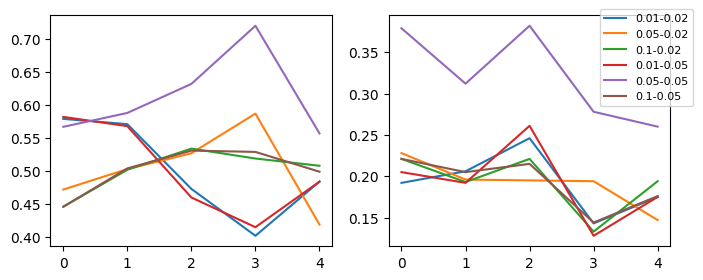


==============multilingual-e5-large climate-fever=================



FileNotFoundError: [Errno 2] No such file or directory: '/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/gradnorm/multilingual-e5-large/climate-fever-result-0.02-temp-0.01'

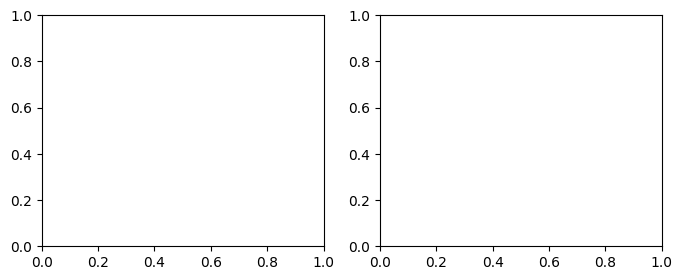

In [67]:
root = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/"
n_aug = 16
gradnorm_func = ("min", "mean")[1]

for model_name in ["gte-base", "multilingual-e5-large"]:
    for dataset_name in ["climate-fever"]:
        get_result_dataset_model(
            model_name,
            dataset_name,
            #dropout,
            #temp,
            root,
            n_aug,
            gradnorm_func
        )


==============bge-large-en-v1.5 nfcorpus=================



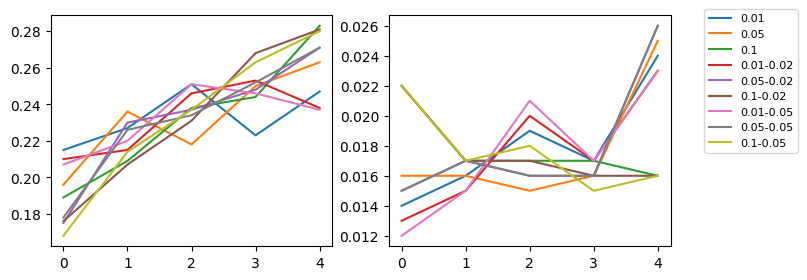


==============bge-large-en-v1.5 trec-covid=================



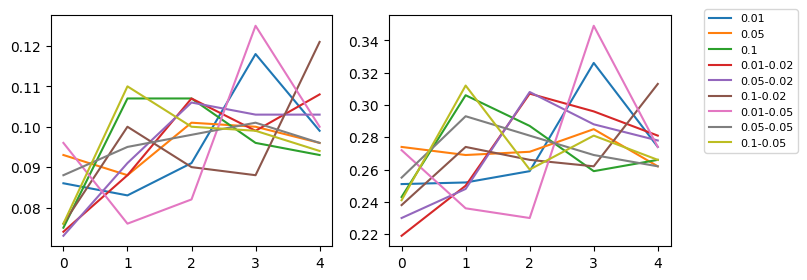


==============contriever nfcorpus=================



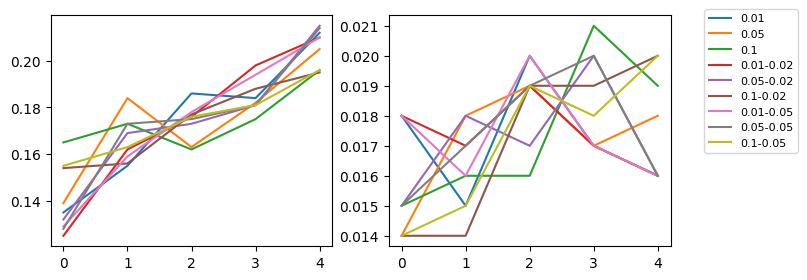


==============contriever trec-covid=================



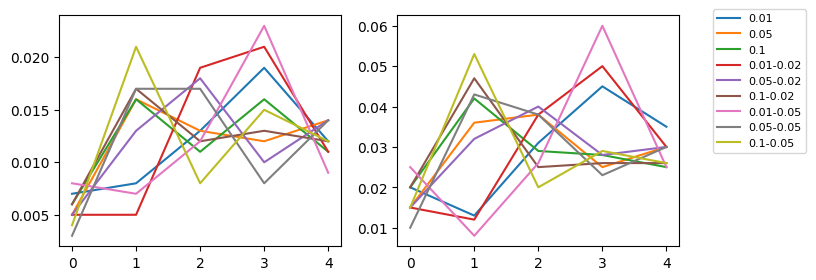


==============gte-base nfcorpus=================



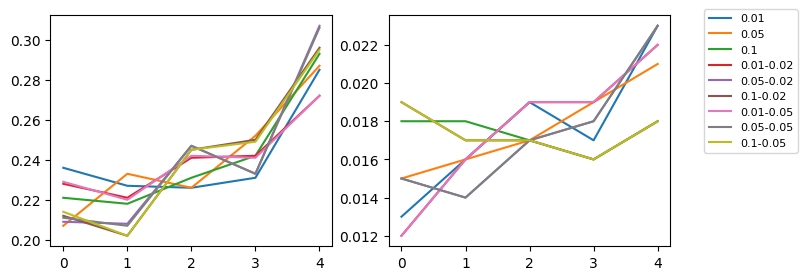


==============gte-base trec-covid=================



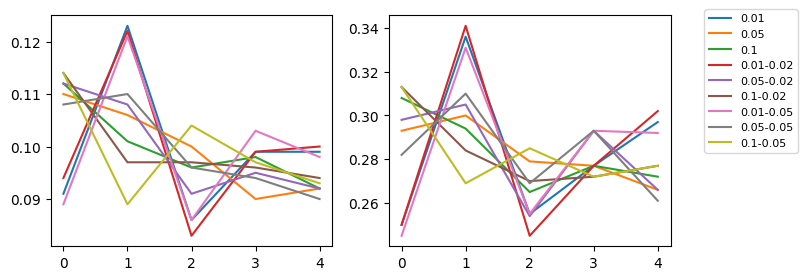


==============multilingual-e5-large nfcorpus=================



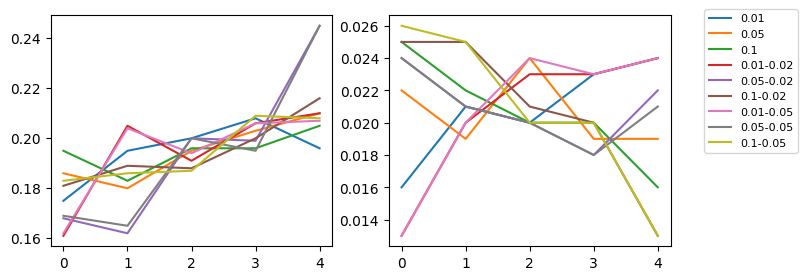


==============multilingual-e5-large trec-covid=================



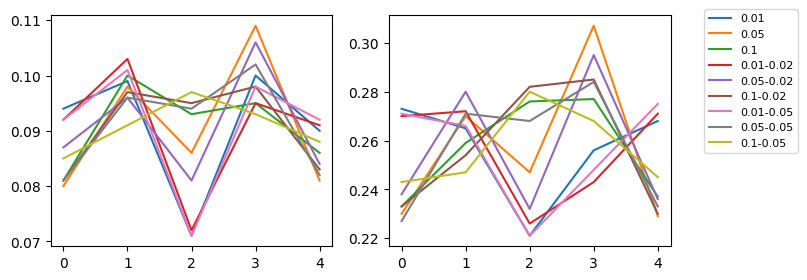

In [8]:
root = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/"
n_aug = 16
gradnorm_func = ("min", "mean")[1]

for model_name in ["bge-large-en-v1.5", "contriever", "gte-base", "multilingual-e5-large"]:
    for dataset_name in ["nfcorpus", "trec-covid"]:
        get_result_dataset_model(
            model_name,
            dataset_name,
            #dropout,
            #temp,
            root,
            n_aug,
            gradnorm_func
        )

In [9]:
def get_result_dataset_model_dropout(
    model_name,
    dataset_name,
    dropout,
    root,
    n_aug,
    gradnorm_func,
    interval=5
):    
    fig, axs = plt.subplots(1,2, figsize=(8, 3))

    def calculate_avg_for_each_interval(gradnorm_dict, metric_dict, interval):
        integrated_output = [[gradnorm_dict[i], metric_dict[i]] for i in metric_dict.keys()]
        integrated_output = sorted(integrated_output, key=lambda x: x[0], reverse=True)
        means = []
        for r in range(interval):
            start_percentage = r / interval
            end_percentage = (r+1) / interval
            start = int(len(integrated_output) * start_percentage)
            end = int(len(integrated_output) * end_percentage)
            sub_output = integrated_output[start:end]
            scores = [i[1] for i in sub_output]
            mean = round(sum(scores) / len(scores), 3)
            means.append(mean)
        return means
    
    print(f"\n============== {model_name} / {dataset_name} / {dropout} =================\n")
    xs = [i * (100//interval) for i in range(100//interval)]
    legends = []
    for temp in [0.01, 0.05, 0.1]:
        # Load results
        gradnorm_path = root + f"gradnorm/{model_name}/{dataset_name}-result{dropout}-temp-{temp}"
        gradnorm_dict = get_gradnorms(gradnorm_path)
        recall_path = root + f"retrieval/results/{model_name}/{dataset_name}-n-query-mt-2.csv"
        recall_dict, precision_dict = get_recalls_and_precisions(recall_path, gradnorm_dict.keys())
        gradnorm_dict = {i: gradnorm_dict[i] for i in recall_dict.keys()}
        # Calculate metric
        results_r = calculate_avg_for_each_interval(gradnorm_dict, recall_dict, interval)
        results_p = calculate_avg_for_each_interval(gradnorm_dict, precision_dict, interval)
        axs[0].plot(results_r)
        axs[1].plot(results_p)
        legends.append(f"{temp}{dropout}")
    axs[1].legend(legends, fontsize=8, bbox_to_anchor=(1.1, 1.05))
    plt.show()
    


============== bge-large-en-v1.5 / trec-covid /  =================



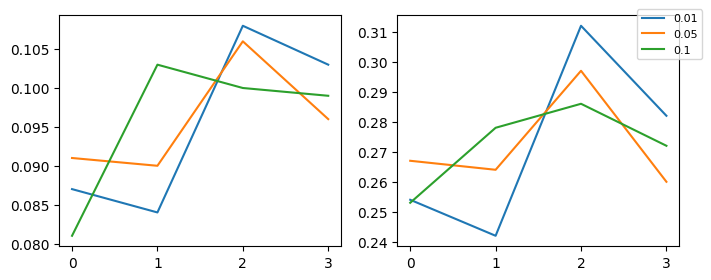


============== bge-large-en-v1.5 / trec-covid / -0.02 =================



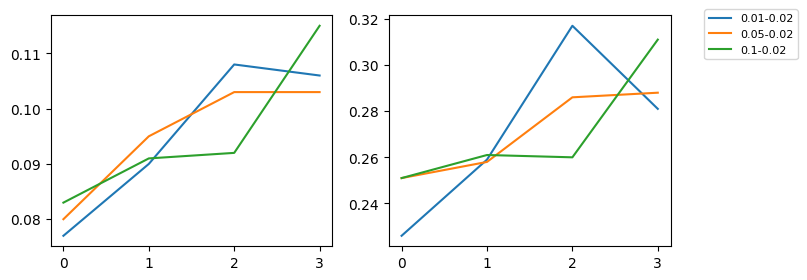


============== bge-large-en-v1.5 / trec-covid / -0.05 =================



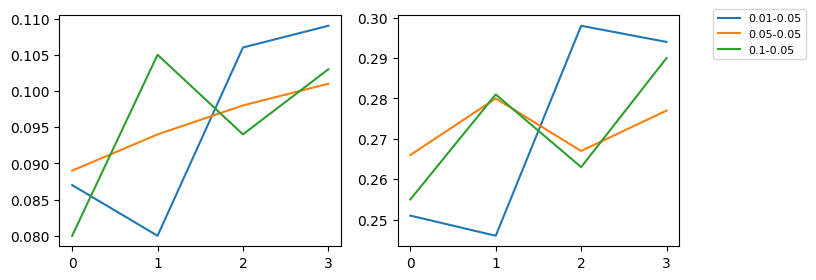


============== contriever / trec-covid /  =================



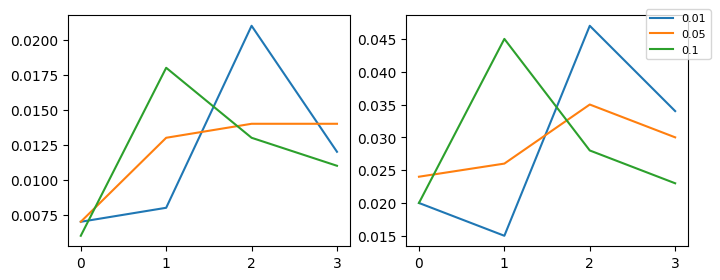


============== contriever / trec-covid / -0.02 =================



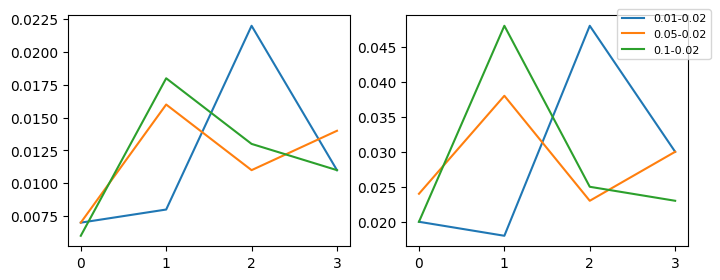


============== contriever / trec-covid / -0.05 =================



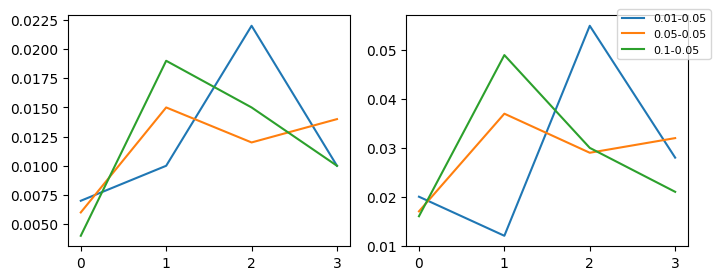


============== gte-base / trec-covid /  =================



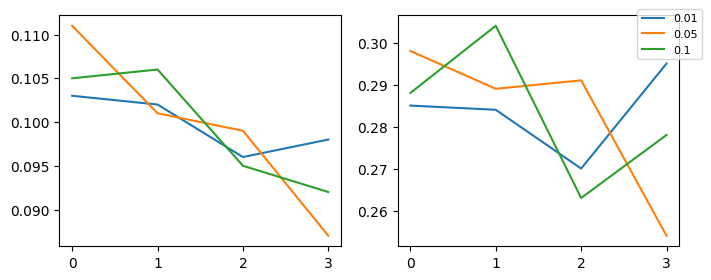


============== gte-base / trec-covid / -0.02 =================



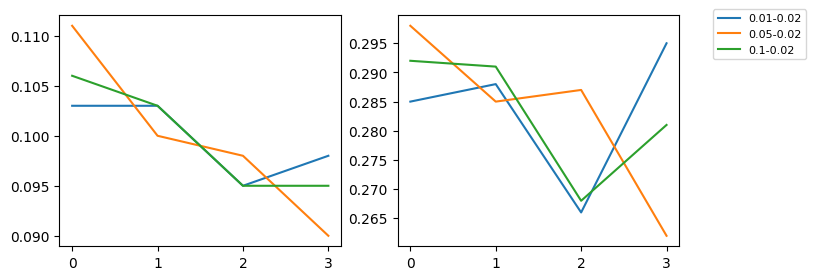


============== gte-base / trec-covid / -0.05 =================



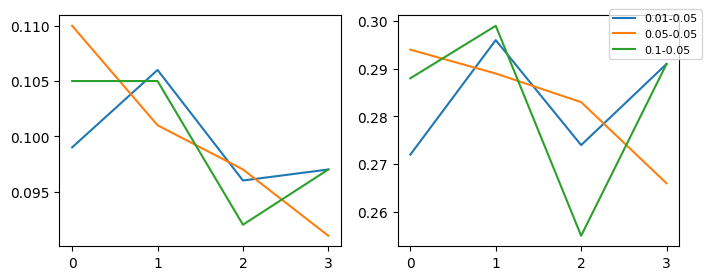


============== multilingual-e5-large / trec-covid /  =================



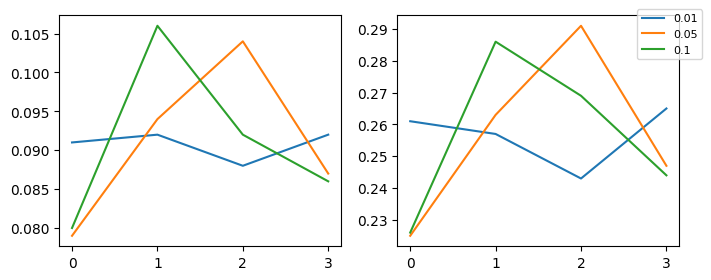


============== multilingual-e5-large / trec-covid / -0.02 =================



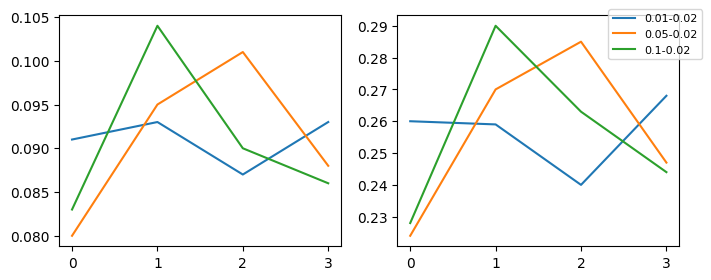


============== multilingual-e5-large / trec-covid / -0.05 =================



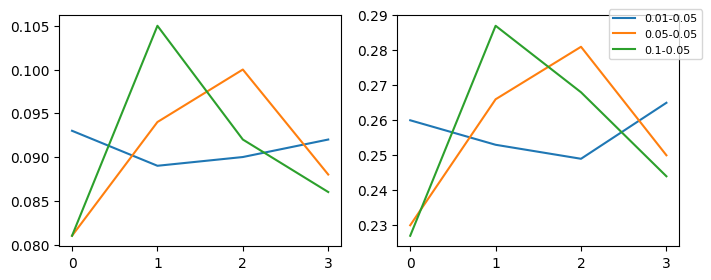


============== bge-large-en-v1.5 / nfcorpus /  =================



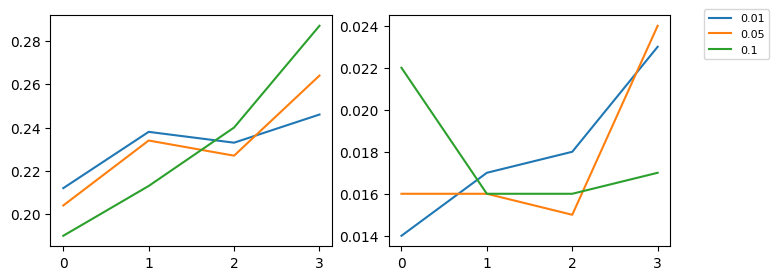


============== bge-large-en-v1.5 / nfcorpus / -0.02 =================



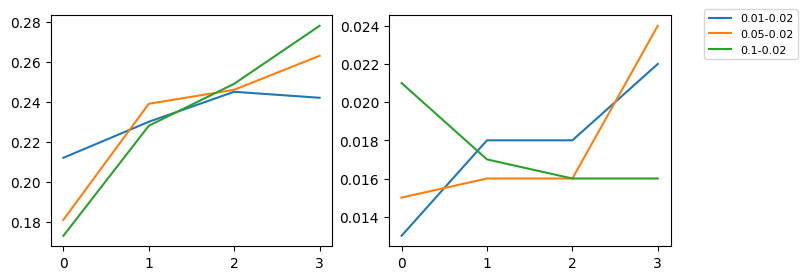


============== bge-large-en-v1.5 / nfcorpus / -0.05 =================



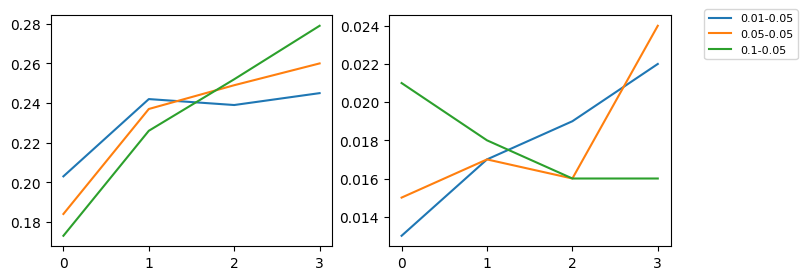


============== contriever / nfcorpus /  =================



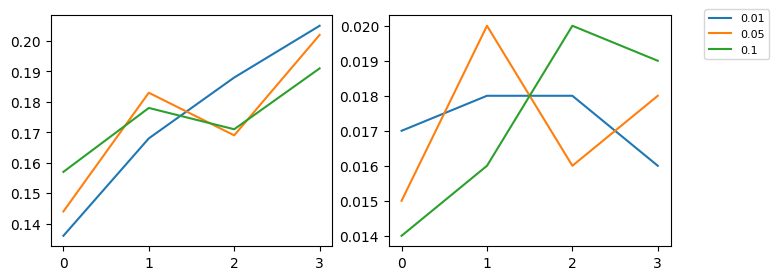


============== contriever / nfcorpus / -0.02 =================



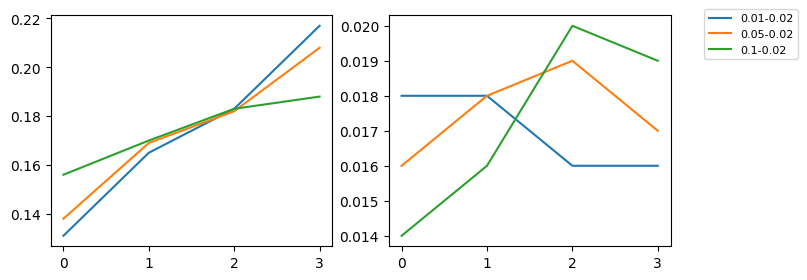


============== contriever / nfcorpus / -0.05 =================



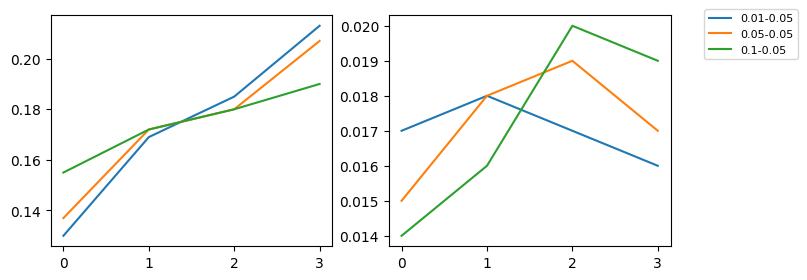


============== gte-base / nfcorpus /  =================



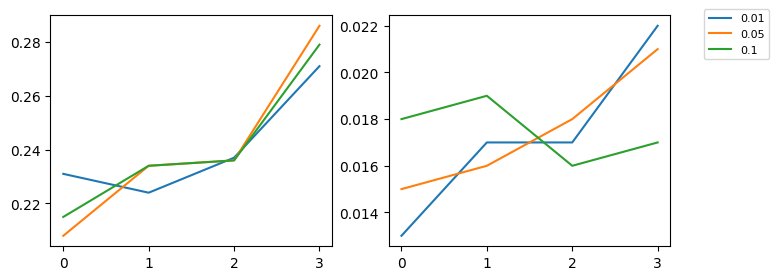


============== gte-base / nfcorpus / -0.02 =================



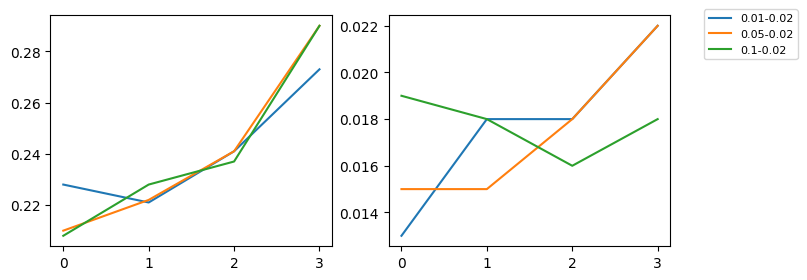


============== gte-base / nfcorpus / -0.05 =================



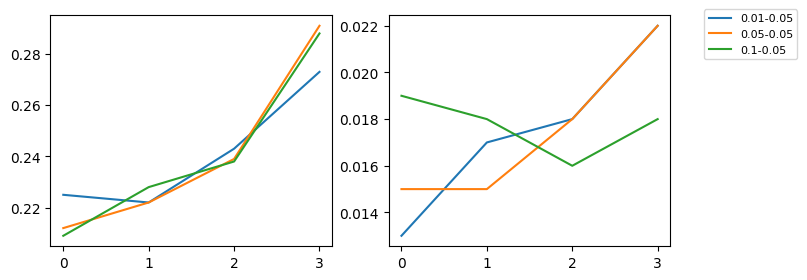


============== multilingual-e5-large / nfcorpus /  =================



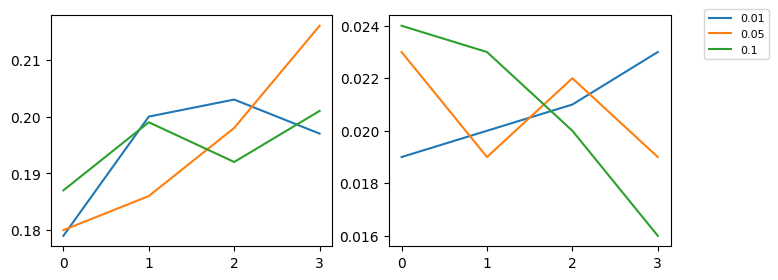


============== multilingual-e5-large / nfcorpus / -0.02 =================



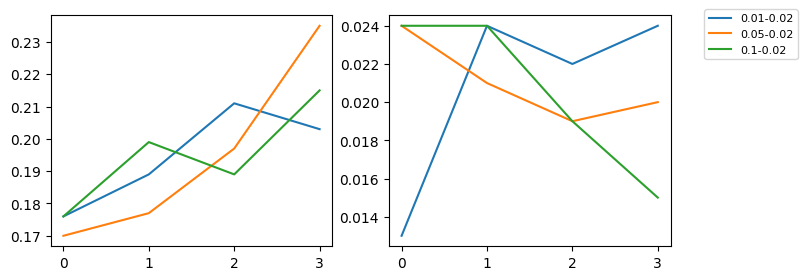


============== multilingual-e5-large / nfcorpus / -0.05 =================



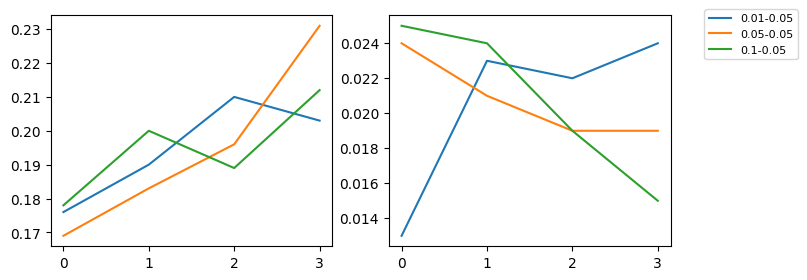

In [13]:
root = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/"
n_aug = 16
gradnorm_func = ("min", "mean")[1]

for dataset_name in ["trec-covid", "nfcorpus"]:
    for model_name in ["bge-large-en-v1.5", "contriever", "gte-base", "multilingual-e5-large"]:
        for dropout in ["", "-0.02", "-0.05"]:
            get_result_dataset_model_dropout(
                model_name,
                dataset_name,
                dropout,
                #temp,
                root,
                n_aug,
                gradnorm_func,
                4
            )

## Plot all result points

In [299]:
def plot_all_results(
    model_name,
    dataset_name,
    dropout,
    root,
    n_aug,
    gradnorm_func,
    interval=5
):    
    fig, axs = plt.subplots(1,2, figsize=(8, 3))

    def get_sorted_dict(gradnorm_dict, dic1, dic2):
        integrated_output = [[gradnorm_dict[i], dic1[i], dic2[i]]  for i in gradnorm_dict.keys()]
        integrated_output = sorted(integrated_output, key=lambda x: x[0], reverse=True)
        gradnorm_sorted = [i[0] for i in integrated_output]
        sorted1 = [i[1] for i in integrated_output]
        sorted2 = [i[2] for i in integrated_output]
        return gradnorm_sorted, sorted1, sorted2
    
    print(f"\n============== {model_name} / {dataset_name} / {dropout} =================\n")
    xs = [i * (100//interval) for i in range(100//interval)]
    legends = []
    for temp in [0.05]: #[0.01, 0.05, 0.1]:
        # Load results
        gradnorm_path = root + f"gradnorm/{model_name}/{dataset_name}-result{dropout}-temp-{temp}"
        gradnorm_dict = get_gradnorms(gradnorm_path)
        recall_path = root + f"retrieval/results/{model_name}/{dataset_name}-n-query-mt-2.csv"
        recall_dict, precision_dict = get_recalls_and_precisions(recall_path, gradnorm_dict.keys())
        gradnorm_dict = {i: gradnorm_dict[i] for i in recall_dict.keys()}

        gradnorm_sorted, recall_sorted, precision_sorted = get_sorted_dict(
            gradnorm_dict, recall_dict, precision_dict)
        
        # Calculate metric
        print(slope1, y_intercept1)
        axs[0].plot(recall_dict.values())
        axs[1].plot(precision_dict.values())
        legends.append(f"{temp}{dropout}")
    axs[1].legend(legends, fontsize=8, bbox_to_anchor=(1.1, 1.05))
    plt.show()
    


============== gte-base / nfcorpus / -0.02 =================

-0.007835729225198611 0.3274886288665217


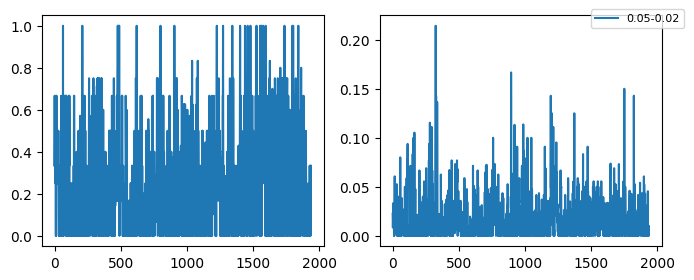

In [302]:
plot_all_results(
    model_name="gte-base",
    dataset_name="nfcorpus",
    dropout="-0.02",
    root=root,
    n_aug=n_aug,
    gradnorm_func=gradnorm_func
)